In [75]:
import numpy as np 
import pandas as pd
import cPickle as pkl
from matplotlib import pyplot as plt
import time

import theano_time_corex
import linearcorex

import random
from scipy.stats import multivariate_normal
import sklearn.covariance as skcov
from sklearn.decomposition import FactorAnalysis

from generate_data import generate_nglf_from_matrix, generate_nglf_from_model

# Generate Data

In [3]:
nt = 10
m = 8
nv = m * 64
train_cnt = 8
test_cnt = 100

snr = 5.0
min_var = 1.0
max_var = 1.0

(data1, sigma1) = generate_nglf_from_model(nv, m, nt // 2, ns=train_cnt + test_cnt, snr=snr, min_var=min_var, max_var=max_var)
(data2, sigma2) = generate_nglf_from_model(nv, m, nt // 2, ns=train_cnt + test_cnt, snr=snr, min_var=min_var, max_var=max_var)

data = data1 + data2
ground_truth = [sigma1 for i in range(nt // 2)] + [sigma2 for i in range(nt // 2)]

X = [x[:train_cnt] for x in data]
Y = [x[train_cnt:] for x in data]

Fixed SNR: 5.0
Fixed SNR: 5.0


## save the data 

In [74]:
all_data = {
    'nt': nt,
    'm': m,
    'nv': nv,
    'train_cnt': train_cnt,
    'test_cnt': test_cnt,
    'X': X,
    'ground_truth': ground_truth,
    'Y': Y,
    'snr': 5.0,
    'min_var': min_var,
    'max_var': max_var,
}
with open("saved_data/synthetic-buckets-nglf.nt{}.nv{}.m{}.ns{}.pkl".format(nt, nv, m, train_cnt), 'wb') as f:
    pkl.dump(all_data, f)

### Ground Truth Covariance 

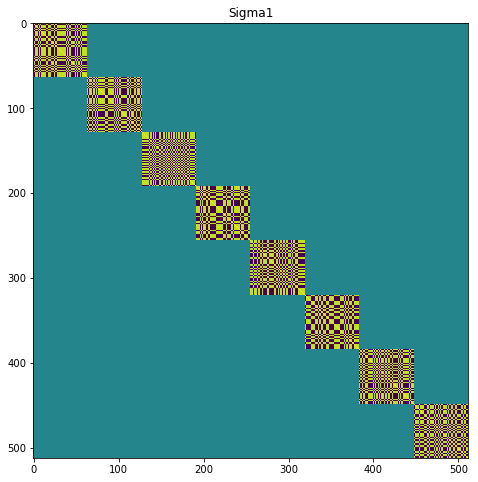

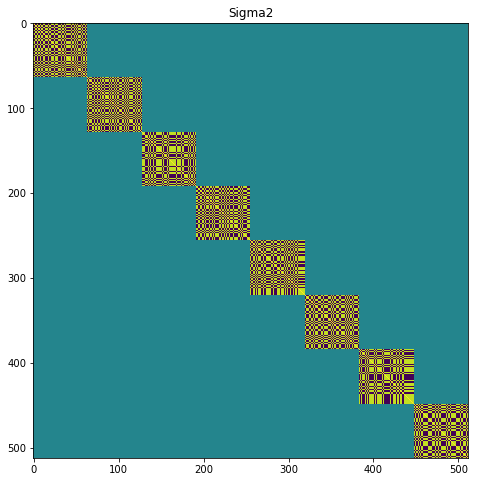

In [4]:
if ground_truth[0] is not None:
    plt.figure(figsize=(8, 8))
    plt.title("Sigma1")
    plt.imshow(sigma1)
    plt.show()
    
if ground_truth[-1] is not None:
    plt.figure(figsize=(8, 8))
    plt.title("Sigma2")
    plt.imshow(sigma2)
    plt.show()

### Sample covariance matrix using test data

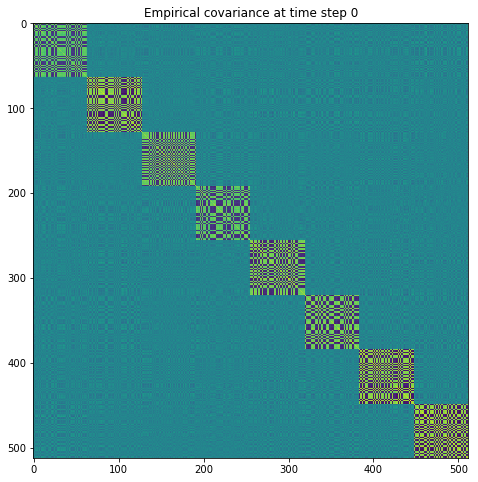

In [6]:
plt.figure(figsize=(8, 8))
plt.title("Empirical covariance at time step 0")
plt.imshow(np.cov(Y[0].T))
plt.show()

### Some functions

In [76]:
def plot_for_next_timestep(covs, title="Negative log-likelihood of estimate of time step $t$ under the test data of timestep $t + 1$"):
    nll = [-np.mean([multivariate_normal.logpdf(sx, cov=covs[t]) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
    plt.bar(range(1, nt), nll, width=0.6)
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylim(0)
    plt.ylabel("Negative log-likelihood")
    plt.xticks(range(1, nt))
    plt.show()
    print "NLL for next time step = {}".format(np.mean(nll))
    return np.mean(nll)

#### Negative log-likelihood of cov. estimate on each timestep. We report the sum of negative log-likelihood over timesteps.

In [8]:
def calculate_score(covs):
    nll = [-np.mean([multivariate_normal.logpdf(sx, cov=covs[t]) for sx in x]) for x,t in zip(Y, range(nt))]
    return np.mean(nll)

# Ground Truth Statistics

#### This graph shows how well the covariance at timestep t models the test data at timestep t+1. Clearly we should see a peak at the middle timestep.

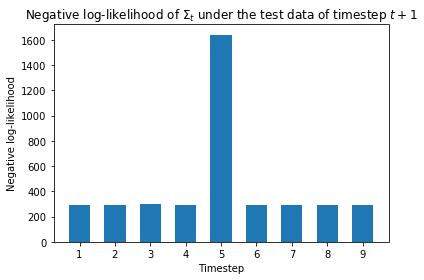

NLL for next time step = 441.666628195


In [9]:
if ground_truth[0] is not None:
    plot_for_next_timestep(ground_truth, title="Negative log-likelihood of $\Sigma_t$ under the test data of timestep $t + 1$");

#### Negative log-likelihood of cov. estimate on each timestep. We report the sum of negative log-likelihood over timesteps.

In [10]:
if ground_truth[0] is not None:
    print "Final NLL = {}".format(calculate_score(ground_truth))

Final NLL = 291.262241277


# Learn independent linear corexes on each timestep

In [11]:
cs = []
for x in X:
    c = linearcorex.Corex(n_hidden=m,
                          max_iter=500,
                          anneal=True)
    c.fit(x)
    cs.append(c)
    
print sum([c.tc for c in cs])

6072.75753021


In [12]:
cs_covs = [c.get_covariance() for c in cs]

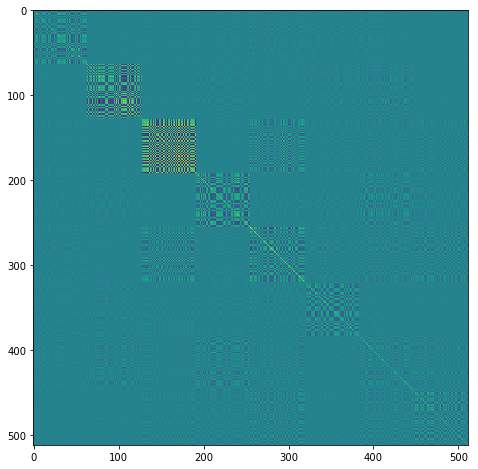

In [13]:
plt.figure(figsize=(8,8))
plt.imshow(cs_covs[0])
plt.show()

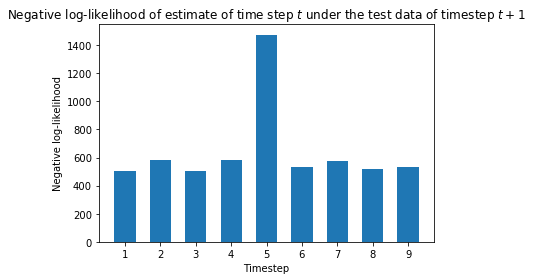

NLL for next time step = 644.729502714


In [14]:
plot_for_next_timestep(cs_covs);

In [15]:
print "Final NLL = {}".format(calculate_score(cs_covs))

Final NLL = 567.823646833


# L1 regularization on the difference of neighbouring covariance estimates

In [25]:
best_nll = np.inf
best_csig = None
best_l1 = None
coefs = [0, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1]
nlls = []
for l1 in coefs:
    print "training with l1 = {}".format(l1)
    csig = theano_time_corex.TimeCorexSigma(nt=nt,
                                            nv=nv,
                                            n_hidden=m,
                                            max_iter=500,
                                            verbose=False,
                                            anneal=True,
                                            l1=l1)
    csig.fit(X)
    csig_covs = csig.get_covariance()
    nll = calculate_score(csig_covs)
    nlls.append(nll)
    print "l1 = {}, nll = {}".format(l1, nll)
    if np.mean(nll) < best_nll:
        best_nll = np.mean(nll)
        best_csig = csig
        best_l1 = l1

print "best l1 = {}".format(best_l1)
csig = best_csig
print sum(csig.tc)

training with l1 = 0
Annealing iteration finished, time = 3.92473292351
Annealing iteration finished, time = 3.95697212219
Annealing iteration finished, time = 3.95018696785
Annealing iteration finished, time = 3.86821699142
Annealing iteration finished, time = 3.92202997208
Annealing iteration finished, time = 3.98386406898
Annealing iteration finished, time = 3.87512612343
l1 = 0, nll = 566.091390903
training with l1 = 1e-05
Annealing iteration finished, time = 17.1997869015
Annealing iteration finished, time = 16.8511049747
Annealing iteration finished, time = 16.7272500992
Annealing iteration finished, time = 16.6710591316
Annealing iteration finished, time = 16.6406130791
Annealing iteration finished, time = 16.7206599712
Annealing iteration finished, time = 16.7748930454
l1 = 1e-05, nll = 570.347110189
training with l1 = 3e-05
Annealing iteration finished, time = 17.3357729912
Annealing iteration finished, time = 16.9424438477
Annealing iteration finished, time = 17.0299909115
An

In [26]:
csig_covs = csig.get_covariance()

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(csig_covs[0])
plt.show()

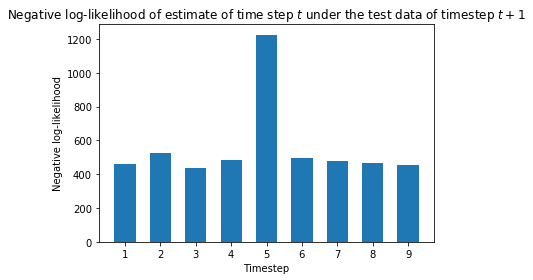

NLL for next time step = 558.481398416


In [28]:
plot_for_next_timestep(csig_covs);

In [29]:
print "Final NLL = {}".format(calculate_score(csig_covs))

Final NLL = 497.884072466


# Diagonal matrix

In [16]:
diag_covs = []
for x in X:
    diag_covs.append(np.diag(np.var(x, axis=0)))

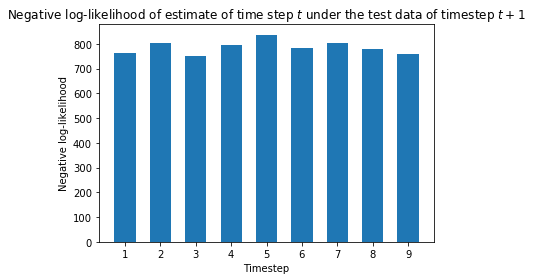

NLL for next time step = 785.828200643


In [17]:
plot_for_next_timestep(diag_covs);

In [18]:
print "Final NLL = {}".format(calculate_score(diag_covs))

Final NLL = 790.554025943


## Ledoit-Wolf Estimation

In [19]:
lw_covs = []
for x in X:
    lw_est = skcov.LedoitWolf()
    lw_est.fit(x)
    lw_covs.append(lw_est.covariance_)

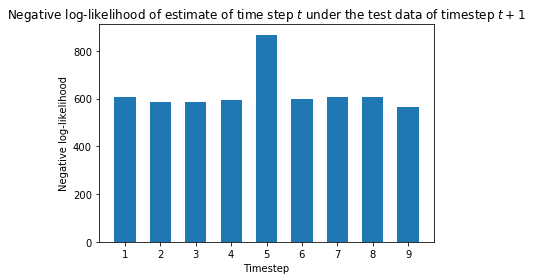

NLL for next time step = 623.797399088


In [20]:
plot_for_next_timestep(lw_covs);

In [21]:
print "Final NLL = {}".format(calculate_score(lw_covs))

Final NLL = 593.774887303


## Oracle Approximating Shrinkage

In [22]:
oas_covs = []
for x in X:
    oas_est = skcov.OAS()
    oas_est.fit(x)
    oas_covs.append(oas_est.covariance_)

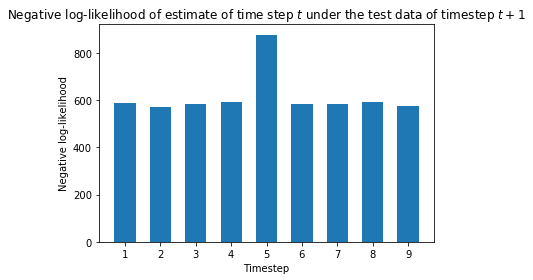

NLL for next time step = 616.998561254


In [23]:
plot_for_next_timestep(oas_covs);

In [24]:
print "Final NLL = {}".format(calculate_score(oas_covs))

Final NLL = 587.327780196


# Factor Analysis

In [45]:
factor_covs = []
for x in X:
    factor_est = FactorAnalysis(n_components=m)
    factor_est.fit(x)
    factor_covs.append(factor_est.get_covariance())

In [46]:
# factor_covs = [x + 1e-6 * np.eye(nv) for x in factor_covs]

In [47]:
plot_for_next_timestep(factor_covs);

LinAlgError: singular matrix

In [48]:
print "Final NLL = {}".format(calculate_score(factor_covs))

LinAlgError: singular matrix

## Graphical LASSO

In [30]:
glasso_covs = []
for x in X:
    glasso_est = skcov.GraphLasso(mode='lars')
    glasso_est.fit(x)
    glasso_covs.append(glasso_est.covariance_)

OverflowError: long int too large to convert to float

In [ ]:
plot_for_next_timestep(glasso_covs);

In [ ]:
print "Final NLL = {}".format(calculate_score(glasso_covs))

# Time Varying Graphical Lasso

In [49]:
import sys
sys.path.append('../TVGL/')
from TVGL import TVGL

In [60]:
cur_data = []
for x in X:
    cur_data += list(x)
cur_data = np.array(cur_data)

In [64]:
tvgl_covs = TVGL(data=cur_data,
                lengthOfSlice=train_cnt,
                lamb=0.001,
                beta=0.1,
                indexOfPenalty=1,
                verbose=True)

Use l-1 penalty function
10
lambda = 0.001, beta = 0.1
Distributed ADMM (4 processors)
Iteration 1
  r: 3.99308265761
  e_pri: 1.21693367281
  s: 118.599488607
  e_dual: 1.92241705057
Iteration 2
  r: 4.07243405498
  e_pri: 1.26020365146
  s: 72.8867597102
  e_dual: 1.92655778784
Iteration 3
  r: 4.30161959678
  e_pri: 1.29340359269
  s: 55.9580125468
  e_dual: 1.93047227004
Iteration 4
  r: 4.51020991325
  e_pri: 1.32104352021
  s: 46.6522572642
  e_dual: 1.93457307028
Iteration 5
  r: 4.62490692442
  e_pri: 1.34505476545
  s: 40.6131804537
  e_dual: 1.93858212084
Iteration 6
  r: 4.68917784626
  e_pri: 1.3664740025
  s: 36.3019387281
  e_dual: 1.94243188758
Iteration 7
  r: 4.71593225905
  e_pri: 1.3859233915
  s: 33.0320685734
  e_dual: 1.94611552794
Iteration 8
  r: 4.70484756354
  e_pri: 1.40381097189
  s: 30.4469120252
  e_dual: 1.94963232723
Iteration 9
  r: 4.65819726693
  e_pri: 1.42042286997
  s: 28.3406306843
  e_dual: 1.95297247362
Iteration 10
  r: 4.57938881815
  e_pri: 1

Iteration 84
  r: 0.374863257012
  e_pri: 1.98153465505
  s: 8.30420638694
  e_dual: 1.96989275553
Iteration 85
  r: 0.375455561022
  e_pri: 1.98638368927
  s: 8.25165278945
  e_dual: 1.96986244185
Iteration 86
  r: 0.376581267593
  e_pri: 1.99120350216
  s: 8.20017477244
  e_dual: 1.96982680528
Iteration 87
  r: 0.377676877619
  e_pri: 1.9959946704
  s: 8.14979924293
  e_dual: 1.96978604781
Iteration 88
  r: 0.378226380155
  e_pri: 2.00075774393
  s: 8.10052970994
  e_dual: 1.96974041351
Iteration 89
  r: 0.377817074946
  e_pri: 2.00549324167
  s: 8.05234534701
  e_dual: 1.96969020986
Iteration 90
  r: 0.376232037594
  e_pri: 2.0102016554
  s: 8.00523390297
  e_dual: 1.96963577333
Iteration 91
  r: 0.373271655456
  e_pri: 2.01488346073
  s: 7.95918128954
  e_dual: 1.96957751098
Iteration 92
  r: 0.368873766402
  e_pri: 2.01953910429
  s: 7.91415291741
  e_dual: 1.96951587173
Iteration 93
  r: 0.363083693616
  e_pri: 2.02416901274
  s: 7.87008322241
  e_dual: 1.96945131124
Iteration 94

Iteration 167
  r: 0.118548292031
  e_pri: 2.31375355606
  s: 5.75887411221
  e_dual: 1.96717072257
Iteration 168
  r: 0.115403666545
  e_pri: 2.31713688412
  s: 5.7403825908
  e_dual: 1.96715409798
Iteration 169
  r: 0.112749050665
  e_pri: 2.32050941066
  s: 5.72202021138
  e_dual: 1.96713835066
Iteration 170
  r: 0.110681016287
  e_pri: 2.32387122983
  s: 5.70378644643
  e_dual: 1.96712342136
Iteration 171
  r: 0.109228292012
  e_pri: 2.32722243735
  s: 5.68568585479
  e_dual: 1.96710922518
Iteration 172
  r: 0.10831499309
  e_pri: 2.33056313035
  s: 5.66772561117
  e_dual: 1.96709569435
Iteration 173
  r: 0.107942100145
  e_pri: 2.33389340421
  s: 5.64989859515
  e_dual: 1.96708273472
Iteration 174
  r: 0.108060531336
  e_pri: 2.33721335501
  s: 5.63220986714
  e_dual: 1.96707026091
Iteration 175
  r: 0.108515807037
  e_pri: 2.34052307837
  s: 5.61467171976
  e_dual: 1.96705817679
Iteration 176
  r: 0.109105787093
  e_pri: 2.3438226705
  s: 5.59728956448
  e_dual: 1.96704640313
Ite

Iteration 249
  r: 0.0584012213744
  e_pri: 2.56228733254
  s: 4.6489852619
  e_dual: 1.96613911297
Iteration 250
  r: 0.0582213936808
  e_pri: 2.56502367738
  s: 4.63901709963
  e_dual: 1.9661288334
Iteration 251


In [68]:
tvgl_covs=[np.linalg.inv(x) for x in tvgl_covs]

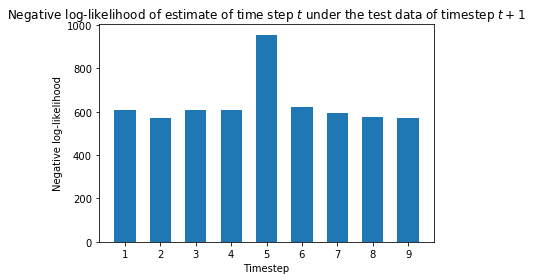

NLL for next time step = 634.309939705


In [70]:
plot_for_next_timestep(tvgl_covs);

In [71]:
print "Final NLL = {}".format(calculate_score(tvgl_covs))

Final NLL = 602.018726089


# Summary of the results


| Model | NLL |  
|:------|----:|  
| ground truth                     | ????????? |  
| independent corexes              | 105237.22 |  
| regularized corex                |  61546.79 |  
| shrinkage estimator (coef = 0.1) | 162136.32 |
| Ledoit-Wolf                      | 52950.41  |
| OAS                              | 49325.46  |
| GLASSO                           | ill cond. |
| Emprical covariance              | ill cond. |
